# Translitertion

## Loading dependences

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
from IPython.display import clear_output

C:\Users\Vidipt\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Vidipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Vidipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Preprocessing and Data Loading

### lookup tables for vocabulary

In [2]:
SPECIAL_TOKENS = {
    '<PAD>': 0,     # Padding token - to equalize size of expressions
}


def lookup_table(vocabulary):
    vocabulary = set(list(vocabulary))
    v2i = copy.copy(SPECIAL_TOKENS)
    for i, vocab in enumerate(vocabulary, len(SPECIAL_TOKENS)):
        v2i[vocab] = i

    i2v = {i:v for v, i in v2i.items()}
    return v2i, i2v

ENG = 'abcdefghijklmnopqrstuvwxyz'
HIN = ''.join(c for c in [chr(alpha) for alpha in range(2304, 2432)])

hin_v2i, hin_i2v = lookup_table(HIN)
eng_v2i, eng_i2v = lookup_table(ENG)

In [3]:
print(eng_v2i)

{'<PAD>': 0, 'l': 1, 't': 2, 'y': 3, 'g': 4, 'o': 5, 'i': 6, 'n': 7, 'w': 8, 'q': 9, 'a': 10, 'v': 11, 'h': 12, 'z': 13, 's': 14, 'd': 15, 'x': 16, 'p': 17, 'c': 18, 'j': 19, 'k': 20, 'm': 21, 'r': 22, 'u': 23, 'f': 24, 'e': 25, 'b': 26}


In [4]:
print(hin_v2i)

{'<PAD>': 0, '८': 1, 'ॢ': 2, 'ो': 3, 'औ': 4, 'ज़': 5, 'ए': 6, 'ठ': 7, '६': 8, 'क़': 9, 'ॆ': 10, 'ज': 11, 'ी': 12, 'ग': 13, 'ॏ': 14, '२': 15, 'घ': 16, 'श': 17, '॒': 18, 'ऴ': 19, 'ड़': 20, 'ॐ': 21, 'ॕ': 22, 'प': 23, 'ॊ': 24, 'ॲ': 25, 'ऽ': 26, 'उ': 27, 'इ': 28, 'छ': 29, 'झ': 30, 'ॳ': 31, 'ऒ': 32, 'ढ़': 33, 'ख': 34, 'म': 35, 'ङ': 36, 'ं': 37, '्': 38, '॥': 39, '।': 40, 'ु': 41, '०': 42, 'व': 43, '३': 44, 'ऊ': 45, '॔': 46, 'आ': 47, 'ि': 48, 'ऋ': 49, 'ड': 50, 'ॎ': 51, 'ौ': 52, 'ञ': 53, 'ट': 54, 'ऑ': 55, 'भ': 56, 'य़': 57, 'ऄ': 58, 'ा': 59, 'ॖ': 60, 'ऐ': 61, 'ऍ': 62, '५': 63, 'ॸ': 64, 'ऱ': 65, 'त': 66, 'फ़': 67, '़': 68, 'क': 69, 'थ': 70, 'ढ': 71, '॰': 72, 'अ': 73, 'ॡ': 74, 'ओ': 75, 'ॶ': 76, 'ॱ': 77, 'ख़': 78, 'ॗ': 79, 'फ': 80, 'ॉ': 81, 'ई': 82, 'ॹ': 83, 'ॷ': 84, 'ध': 85, 'ॼ': 86, 'ः': 87, 'ह': 88, 'द': 89, 'ऀ': 90, 'स': 91, 'य': 92, 'ॺ': 93, 'ष': 94, 'ृ': 95, 'ँ': 96, 'ै': 97, '॑': 98, '७': 99, 'ॄ': 100, 'ल': 101, '९': 102, 'ॣ': 103, 'ऺ': 104, 'ॵ': 105, 'र': 106, 'ऻ': 107, 'ब': 108, 'ू': 109, 'ॽ': 

### Loading Dataset

In [5]:
dataset = pd.read_csv('transliteration.txt', delimiter='\t', encoding='utf-8', na_filter=False, header=None)
print(dataset.shape)
ENG_WORDS = dataset.iloc[:, 0].to_numpy()
HIN_WORDS = dataset.iloc[:, 1].to_numpy()

(30823, 2)


In [6]:
print(ENG_WORDS[1], HIN_WORDS[1])

khushbuu खुशबू


In [7]:
ENG_TRAIN, ENG_TEST, HIN_TRAIN, HIN_TEST = train_test_split( ENG_WORDS,HIN_WORDS,  test_size=0.20)
print(len(HIN_TRAIN), len(HIN_TEST))

24658 6165


### DataLoader

In [8]:
class DataLoader(Dataset):
  def __init__(self, hindi , english):
    self.eng_words = english
    self.hin_words = hindi
    self.shuffle_indices = list(range(len(self.hin_words)))
    self.shuffle_start_idx = 0
    random.shuffle(self.shuffle_indices)

  def __len__(self):
    return len(self.eng_words)

  def __getitem__(self, idx):
    return self.eng_words[idx], self.hin_words[idx]

  def get_random_sample(self):
    return self.__getitem__(np.random.randint(len(self.eng_words)))

  def get_array_batch(self, BATCH_SIZE, arr):
    end = self.shuffle_start_idx + BATCH_SIZE
    batch = []
    if end >= len(self.eng_words):
      
      batch = [arr[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
      end = len(self.eng_words)
    return batch + [arr[i] for i in self.shuffle_indices[self.shuffle_start_idx : end]]

  def get_batches(self, BATCH_SIZE):
    hin_batch = self.get_array_batch(BATCH_SIZE, self.hin_words)
    eng_batch = self.get_array_batch(BATCH_SIZE, self.eng_words)
    self.shuffle_start_idx += BATCH_SIZE + 1

    # Reshuffle
    if self.shuffle_start_idx >= len(self.eng_words):
      random.shuffle(self.shuffle_indices)
      self.shuffle_start_idx = 0

    return eng_batch , hin_batch


In [9]:
train_data = DataLoader(HIN_TRAIN , ENG_TRAIN)
test_data = DataLoader(HIN_TEST , ENG_TEST)

In [10]:
HIN_TEST
ENG_TEST

array(['kamaayi', 'anhoni', 'umang', ..., 'paraaye', 'chal', 'karun'],
      dtype=object)

### Word encoding

In [11]:
def hindi_encoding(word, v2i, device='cpu'):
  rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
  for i, char in enumerate(word):
    pos = v2i[char]
    rep[i][0] = pos
  rep[i+1][0] = v2i['<PAD>']
  return rep


In [12]:
def eng_encoding(word, v2i, device='cpu'):
  rep = torch.zeros(len(word)+1, 1, len(v2i)).to(device)
  for i, char in enumerate(word):
    pos = v2i[char]
    rep[i][0][pos] = 1

  pad_pos = v2i['<PAD>']
  rep[i+1][0][pad_pos] = 1
  return rep


In [13]:
eng , hindi = train_data.get_random_sample()

In [14]:
print(hindi, hindi_encoding(hindi, hin_v2i))

सींग tensor([[91],
        [12],
        [37],
        [13],
        [ 0]])


In [15]:
hindi_encoding(hindi, hin_v2i).shape

torch.Size([5, 1])

In [16]:
print(eng , eng_encoding(eng, eng_v2i))

seeng tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [17]:
eng_encoding(eng, eng_v2i).shape

torch.Size([6, 1, 27])

## Model: Encoder decoder with Attention

In [18]:
class Encoder_Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, verbose=False):
    super(Encoder_Decoder, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.encoder_rnn = nn.GRU(input_size, hidden_size)
    self.decoder_rnn = nn.GRU(hidden_size*2, hidden_size)
    self.hidden_to_output = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    self.U = nn.Linear(self.hidden_size, self.hidden_size)
    self.W = nn.Linear(self.hidden_size, self.hidden_size)
    self.attention = nn.Linear(self.hidden_size, 1)
    self.output_to_hidden = nn.Linear(self.output_size, self.hidden_size)
    self.verbose = verbose


  def forward(self, input, max_output_chars = 30, device='cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attention(torch.tanh(U + W))
            attention_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attention', attention_weights.shape)
            
            attention_applied = torch.bmm(attention_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.output_to_hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attention_applied[0]), 1).unsqueeze(0)
            
            if self.verbose:
                print('Attention LC', attention_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn(decoder_input, decoder_state)
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.hidden_to_output(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [19]:
enc_dec = Encoder_Decoder( len(eng_v2i),256, len(hin_v2i), True)

In [20]:
enc_dec.get_parameter

<bound method Module.get_parameter of Encoder_Decoder(
  (encoder_rnn): GRU(27, 256)
  (decoder_rnn): GRU(512, 256)
  (hidden_to_output): Linear(in_features=256, out_features=129, bias=True)
  (softmax): LogSoftmax(dim=2)
  (U): Linear(in_features=256, out_features=256, bias=True)
  (W): Linear(in_features=256, out_features=256, bias=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (output_to_hidden): Linear(in_features=129, out_features=256, bias=True)
)>

In [21]:
sum([param.nelement() for param in enc_dec.parameters()])

1008514

## Training

In [36]:
def train(model, optimizer, criterion, BATCH_SIZE, device='cpu', force=False):
  model.train().to(device)
  optimizer.zero_grad()
  eng_batch , hin_batch = train_data.get_batches(BATCH_SIZE)
  total_loss = 0
  for i in range(BATCH_SIZE):
    
    input_ = eng_encoding(eng_batch[i], eng_v2i, device)
    hind_ = hindi_encoding(hin_batch[i], hin_v2i, device)
    
    
    
    outputs = model.forward(input_, hind_.shape[0], device, ground_truth=hind_ if force else None)
    for i, output in enumerate(outputs):
      loss = criterion(output, hind_[i]) / BATCH_SIZE
      loss.backward(retain_graph=True)
      total_loss += loss

  optimizer.step()
  return total_loss / BATCH_SIZE


In [23]:
def setup(model, LEARNING_RATE=0.01, NUM_BATCHES=10, BATCH_SIZE=10, DISPLAY_STEP=5, device='cpu', e=256):
   model = model.to(device)
   criterion = nn.NLLLoss(ignore_index=-1)
   optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
   force_upto = NUM_BATCHES // 3
   loss_arr = np.zeros(NUM_BATCHES+1)

   for i in range(NUM_BATCHES):
     loss_arr[i+1] = (loss_arr[i]*i + train(model, optimizer, criterion, BATCH_SIZE, device=device, force=i<force_upto))/(i+1)

     if i % DISPLAY_STEP == DISPLAY_STEP-1:
       clear_output(wait=True)
       print('Iteration', i, 'Loss', loss_arr[i])
       plt.figure(figsize=(12,6))
       plt.plot(loss_arr[1:i])
       plt.xlabel('Iterations')
       plt.ylabel('Loss')
       plt.show()
    
   return loss_arr

In [24]:
enc_dec = Encoder_Decoder(len(eng_v2i) ,256 ,  len(hin_v2i) )

Iteration 999 Loss 0.018823904916644096


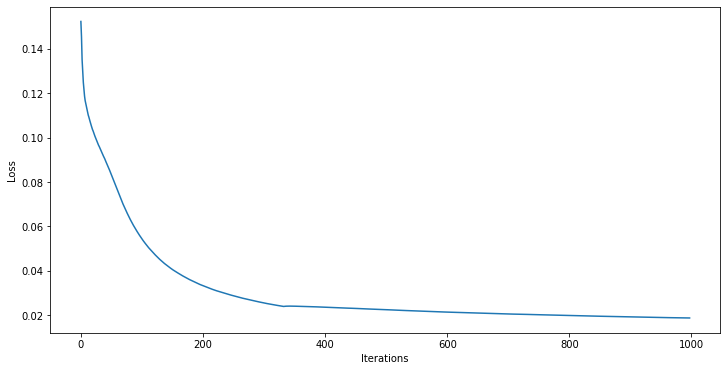

In [25]:
loss = setup(enc_dec, LEARNING_RATE=0.01, NUM_BATCHES=1000, BATCH_SIZE=192, DISPLAY_STEP=10, e=256)

## Save model

In [26]:
torch.save(enc_dec ,  f'model1__lr_0.01_nb=1000_bs=192_e=256.pt')

### Accuracy

In [27]:
def accuracy(model, device='cpu'):
  model = model.eval().to(device)
  preds = []
  acc = 0
  for i in range(len(test_data)):
    english, hindi = test_data[i]
    
    hind_ = hindi_encoding(hindi, hin_v2i, device)

    
    outputs = get_output(model, english, hind_.shape[0], device)
    
    predicted_correctly = 0
    for i, output in enumerate(outputs):
      values, indices = output.topk(1)
      hind_pos = indices.tolist()[0]
        
      if hind_pos[0] == hind_[i][0]:
        predicted_correctly += 1

    acc += predicted_correctly / hind_.shape[0]
  acc /= len(test_data)
  return acc

In [28]:
def get_output(model, word, max_output_chars=30, device='cpu'):
  out = model.forward(eng_encoding(word, eng_v2i), max_output_chars=max_output_chars, device=device)
  return out

### loading model

In [29]:
m1 = torch.load('model1__lr_0.01_nb=1000_bs=192_e=256.pt')
print("Accuracy:", accuracy(m1)*100)

Accuracy: 83.17876711915679


### Sample Test

In [30]:
def test(model, word, device='cpu'):
  model = model.eval().to(device)
  outputs = get_output(model, word, 30, device)
  hin_output = ''
  for output in outputs:
    values, indices = output.topk(1)
    idx = indices.tolist()[0][0]
    if idx == 0: # <PAD>
      break
    char = hin_i2v[idx]
    hin_output += char
  print(word, '->', hin_output)
  return hin_output

### prediction

In [31]:
hindi_out = test(m1, eng)
print("Actual:", eng, "\nPredicted:", hindi_out)

seeng -> सींग
Actual: seeng 
Predicted: सींग


### Sample Prediction

In [32]:
trial_output = get_output(enc_dec, eng)

In [33]:
print('Output Length:', len(trial_output))

Output Length: 30


In [34]:
for i in range(len(trial_output)):
  print(trial_output[i].shape, list(hin_v2i.keys())[list(hin_v2i.values()).index(torch.argmax(trial_output[i]))])

torch.Size([1, 129]) स
torch.Size([1, 129]) ी
torch.Size([1, 129]) ं
torch.Size([1, 129]) ग
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>


In [35]:
print(hindi, eng)


सींग seeng
